In [30]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [31]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint
from holo.__typing import assertIsinstance

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [33]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper1

def cell():
    global handleDatas, train, MoE_models, basicModels
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    MoE_models.paper1 = importlib.reload(MoE_models.paper1)

cell();

In [34]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [35]:
def cell():
    gatingModel, experts, loss = basicModels.BasicImageClassifModel.get_Cifar_like_32x32x3_moe(
        device=device, nbClasses=datasHandler.nbClasses, 
        gatingModelConfig='small', nbExperts=6, expertsModelConfig="small")
    moeModel = MoE_models.paper1.MOE_Model(
        experts=experts, gatingModel=gatingModel, 
        isClassif=True, loadBalance=True, useOriginal=False)
    return moeModel, loss
model, baseLoss = cell(); del cell
hist = train.HistoryClassification()
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
print(f"nbParams gating: {basicModels.countTotalParameters(model.gatingModel.parameters()):_d}")
print(f"""nbParams experts: [{', '.join([f"{basicModels.countTotalParameters(expert.parameters()):_d}" for expert in model.experts])}]""")

trainer = train.TrainerClassif_MoE1(model=model, optimizer=optim, criterion=baseLoss, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
assert _[1].shape == (1, datasHandler.nbClasses, model.nbExperts), f"{_[1].shape = }"
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

nbParams total: 223_458
nbParams gating: 29_286
nbParams experts: [32_362, 32_362, 32_362, 32_362, 32_362, 32_362]


In [36]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=30);

Epoch 1, train: (loss: 0.7902, accuracy: 45.13%), test: (loss: 0.7026, accuracy: 51.89%), lr: 1.0000e-03
Epoch 2, train: (loss: 0.6206, accuracy: 58.29%), test: (loss: 0.635, accuracy: 59.17%), lr: 1.0000e-03
Epoch 3, train: (loss: 0.5539, accuracy: 62.81%), test: (loss: 0.5752, accuracy: 61.52%), lr: 1.0000e-03
Epoch 4, train: (loss: 0.5088, accuracy: 65.92%), test: (loss: 0.5656, accuracy: 62.87%), lr: 1.0000e-03
Epoch 5, train: (loss: 0.4757, accuracy: 68.12%), test: (loss: 0.5184, accuracy: 65.43%), lr: 1.0000e-03
Epoch 6, train: (loss: 0.4463, accuracy: 70.41%), test: (loss: 0.5075, accuracy: 65.28%), lr: 1.0000e-03
Epoch 7, train: (loss: 0.42, accuracy: 71.99%), test: (loss: 0.587, accuracy: 61.16%), lr: 1.0000e-03
Epoch 8, train: (loss: 0.3958, accuracy: 73.45%), test: (loss: 0.4683, accuracy: 68.37%), lr: 1.0000e-03
Epoch 9, train: (loss: 0.3774, accuracy: 74.76%), test: (loss: 0.5263, accuracy: 65.81%), lr: 1.0000e-03
Epoch 10, train: (loss: 0.358, accuracy: 75.92%), test: (lo

In [37]:
def cell():
    
    htest = assertIsinstance(train.Moe1ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
    print(f"-> RESULT")
    print(f"mean: {htest.meanExpertsGate().round(3)} (std: {htest.meanExpertsGate().std(axis=0).round(3)})")
    print(f"std: {htest.meanPredClassesExpertsGate().std(axis=0).round(3)} (mean: {htest.meanPredClassesExpertsGate().std(axis=0).mean().round(3)})")
    print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
    print("\n")
    
    rnd = 2
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        for h in trainer.history:
            htest = assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain = assertIsinstance(train.Moe1ExpertsInsigths, h.train.moeExpertsInsigths)
            print(" ->", h.epochID)
            #print(htest.nbPred.round(rnd))
            #print(htest.nbTruth.round(rnd))
            print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
            print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
            print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
            print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
            print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
            #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
            #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
            print()
    

cell(); del cell

-> RESULT
mean: [0.195 0.216 0.134 0.196 0.116 0.143] (std: 0.037)
std: [0.155 0.107 0.143 0.189 0.1   0.153] (mean: 0.141)
perClassPred: 
[[0.37 0.25 0.13 0.09 0.07 0.04 0.04 0.09 0.4  0.46]
 [0.13 0.18 0.2  0.31 0.14 0.4  0.15 0.41 0.09 0.19]
 [0.37 0.15 0.09 0.03 0.03 0.03 0.   0.02 0.42 0.17]
 [0.05 0.06 0.31 0.3  0.27 0.19 0.64 0.03 0.01 0.03]
 [0.05 0.34 0.07 0.23 0.02 0.2  0.01 0.09 0.07 0.14]
 [0.03 0.02 0.2  0.04 0.47 0.13 0.16 0.36 0.   0.01]]


 -> 1
delta (nbPred-nbTruth) per class[test]:
 [ -94  757   -4  279 -603  178 -257 -186  441 -511]
mean experts use[train]: [0.17 0.13 0.17 0.21 0.14 0.17]
mean experts use[test]: [0.17 0.16 0.12 0.35 0.07 0.14]
mean experts use per class predicted [test]:
[[0.37 0.21 0.09 0.1  0.01 0.04 0.   0.07 0.39 0.25]
 [0.16 0.21 0.11 0.16 0.03 0.12 0.03 0.2  0.19 0.33]
 [0.28 0.16 0.06 0.07 0.   0.03 0.   0.05 0.28 0.12]
 [0.07 0.19 0.56 0.45 0.74 0.56 0.84 0.28 0.03 0.14]
 [0.06 0.14 0.03 0.06 0.01 0.07 0.   0.04 0.09 0.06]
 [0.06 0.08 0.15 0

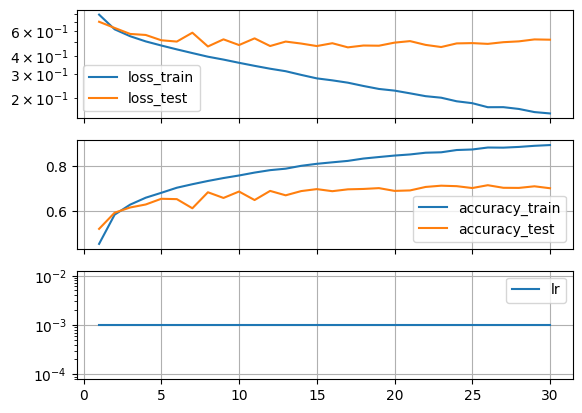

In [38]:
trainer.history.plot();

In [39]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
cell(); del cell

Epoch 1, train: (loss: 0.7902, accuracy: 45.13%), test: (loss: 0.7026, accuracy: 51.89%), lr: 1.0000e-03
        Epoch 2, train: (loss: 0.6206, accuracy: 58.29%), test: (loss: 0.635, accuracy: 59.17%), lr: 1.0000e-03
        Epoch 3, train: (loss: 0.5539, accuracy: 62.81%), test: (loss: 0.5752, accuracy: 61.52%), lr: 1.0000e-03
        Epoch 4, train: (loss: 0.5088, accuracy: 65.92%), test: (loss: 0.5656, accuracy: 62.87%), lr: 1.0000e-03
        Epoch 5, train: (loss: 0.4757, accuracy: 68.12%), test: (loss: 0.5184, accuracy: 65.43%), lr: 1.0000e-03
        Epoch 6, train: (loss: 0.4463, accuracy: 70.41%), test: (loss: 0.5075, accuracy: 65.28%), lr: 1.0000e-03
        Epoch 7, train: (loss: 0.42, accuracy: 71.99%), test: (loss: 0.587, accuracy: 61.16%), lr: 1.0000e-03
        Epoch 8, train: (loss: 0.3958, accuracy: 73.45%), test: (loss: 0.4683, accuracy: 68.37%), lr: 1.0000e-03
        Epoch 9, train: (loss: 0.3774, accuracy: 74.76%), test: (loss: 0.5263, accuracy: 65.81%), lr: 1.0000

In [40]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 920   19   78   21   40   14    9   19   66   45]
 [  24  909    1    4    3    5   10    2   23   71]
 [  49   11  721   93   97   73   46   41   11   17]
 [  19   14   71  566   74  208   62   51   21   14]
 [  21    6  123   78  792   66   49   75   10    9]
 [  13   11   85  232   62  683   22   86    8   16]
 [  12   16   90  122   74   43  978   15   12   23]
 [   8    7   38   38   78   53    6  889    3   19]
 [  86   27   20   26   15    9    5    5 1006   31]
 [  47  127   16   30    7   11    6   19   37  957]]

class: 0, precision:74.74%, hitRate: 76.73%
class: 1, precision:86.41%, hitRate: 79.25%
class: 2, precision:62.21%, hitRate: 58.00%
class: 3, precision:51.45%, hitRate: 46.78%
class: 4, precision:64.44%, hitRate: 63.77%
class: 5, precision:56.08%, hitRate: 58.63%
class: 6, precision:70.61%, hitRate: 81.98%
class: 7, precision:78.05%, hitRate: 73.96%
class: 8, precision:81.79%, hitRate: 84.04%
class: 9, precision:76.13%, hitRate: 79.62%

[
    (0.06482257613858619,